In [0]:
import pandas as pd
import io,csv
import requests
import matplotlib.pyplot as plt
import numpy
import gzip
import seaborn as sns
import numpy as np
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [26]:
uploaded = files.upload()

Saving covid19brasil.csv to covid19brasil.csv


In [37]:
ds = pd.read_csv('covid19brasil.csv', encoding='ISO-8859-1', sep=',')
print(ds.shape)

(62286, 16)


In [34]:
ds.head()

,epidemiological_week,date,order_for_place,state,city,city_ibge_code,place_type,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,new_confirmed,last_available_deaths,new_deaths,last_available_death_rate,estimated_population_2019,is_last,is_repeated
0,19,2020-05-08,41,AC,AcrelÃ¢ndia,1200013.0,city,15,98.32197,0,1,0,0.0667,15256.0,False,True
1,19,2020-05-08,8,AC,Assis Brasil,1200054.0,city,1,13.48254,0,0,0,0.0000,7417.0,False,True
2,19,2020-05-08,31,AC,Bujari,1200138.0,city,4,38.96357,0,0,0,0.0000,10266.0,False,True
3,19,2020-05-08,26,AC,Cruzeiro do Sul,1200203.0,city,26,29.41975,0,0,0,0.0000,88376.0,False,True
4,19,2020-05-08,2,AC,EpitaciolÃ¢ndia,1200252.0,city,2,10.86307,0,0,0,0.0000,18411.0,False,True


In [0]:
ds = ds.drop(['order_for_place', 'city_ibge_code', 'place_type', 'last_available_confirmed', 'last_available_confirmed_per_100k_inhabitants', 'is_last', 'is_repeated'], axis=1)

In [39]:
print(ds.shape)

(62286, 9)


In [40]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62286 entries, 0 to 62285
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   epidemiological_week       62286 non-null  int64  
 1   date                       62286 non-null  object 
 2   state                      62286 non-null  object 
 3   city                       60743 non-null  object 
 4   new_confirmed              62286 non-null  int64  
 5   last_available_deaths      62286 non-null  int64  
 6   new_deaths                 62286 non-null  int64  
 7   last_available_death_rate  62286 non-null  float64
 8   estimated_population_2019  61564 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 4.3+ MB


In [49]:
ds.tail(10)

,epidemiological_week,date,state,city,new_confirmed,last_available_deaths,new_deaths,last_available_death_rate,estimated_population_2019
62276,9,2020-02-29,SP,SÃ£o Paulo,0,0,0,0.0,12252023.0
62277,9,2020-02-29,SP,NaN,0,0,0,0.0,45919049.0
62278,9,2020-02-28,SP,SÃ£o Paulo,1,0,0,0.0,12252023.0
62279,9,2020-02-28,SP,NaN,1,0,0,0.0,45919049.0
62280,9,2020-02-27,SP,SÃ£o Paulo,0,0,0,0.0,12252023.0
62281,9,2020-02-27,SP,NaN,0,0,0,0.0,45919049.0
62282,9,2020-02-26,SP,SÃ£o Paulo,0,0,0,0.0,12252023.0
62283,9,2020-02-26,SP,NaN,0,0,0,0.0,45919049.0
62284,9,2020-02-25,SP,SÃ£o Paulo,1,0,0,0.0,12252023.0
62285,9,2020-02-25,SP,NaN,1,0,0,0.0,45919049.0


In [54]:
ds.dtypes

epidemiological_week           int64
date                          object
state                         object
city                          object
new_confirmed                  int64
last_available_deaths          int64
new_deaths                     int64
last_available_death_rate    float64
estimated_population_2019    float64
dtype: object

(62286, 9)

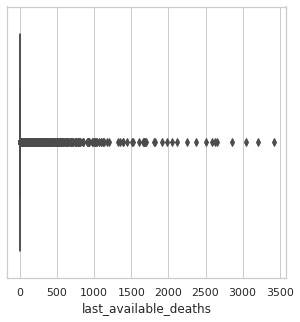

In [62]:
plt.figure(figsize = (5,5))
sns.boxplot(ds["last_available_deaths"])
ds.shape

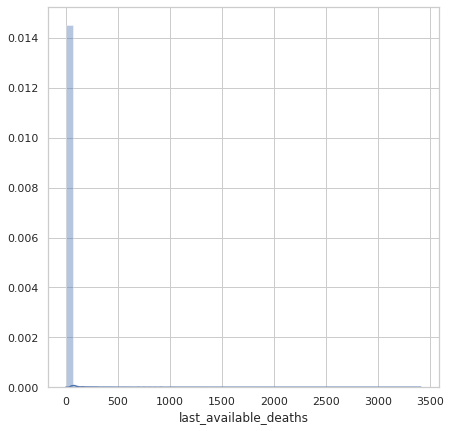

In [66]:
plt.figure(figsize = (7,7))
sns.set(style = "whitegrid")
f = sns.distplot(ds["last_available_deaths"])

In [0]:
q1 = ds["last_available_deaths"].quantile(0.25)
q3 = ds["last_available_deaths"].quantile(0.75)

IQR = q3 - q1
IF = q1 - (1.5 * IQR)
OF = q3 + (1.5 * IQR)

In [68]:
ds = ds[~((ds["last_available_deaths"] < IF) | (ds["last_available_deaths"] > OF))]
ds.shape

(56679, 9)

count    56679.000000
mean         0.262055
std          0.536943
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: last_available_deaths, dtype: float64


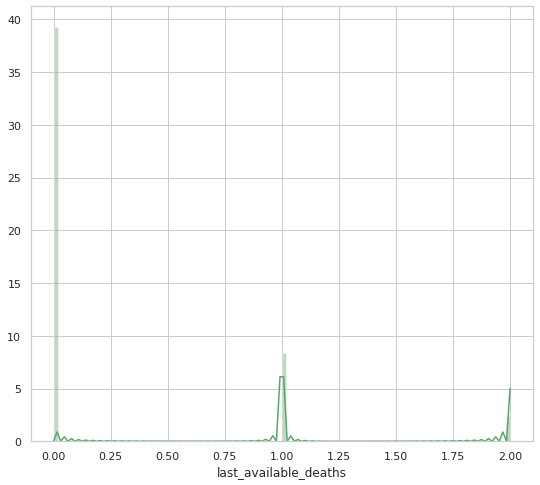

In [69]:
print(ds['last_available_deaths'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(ds['last_available_deaths'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [70]:
list(set(ds.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64')]

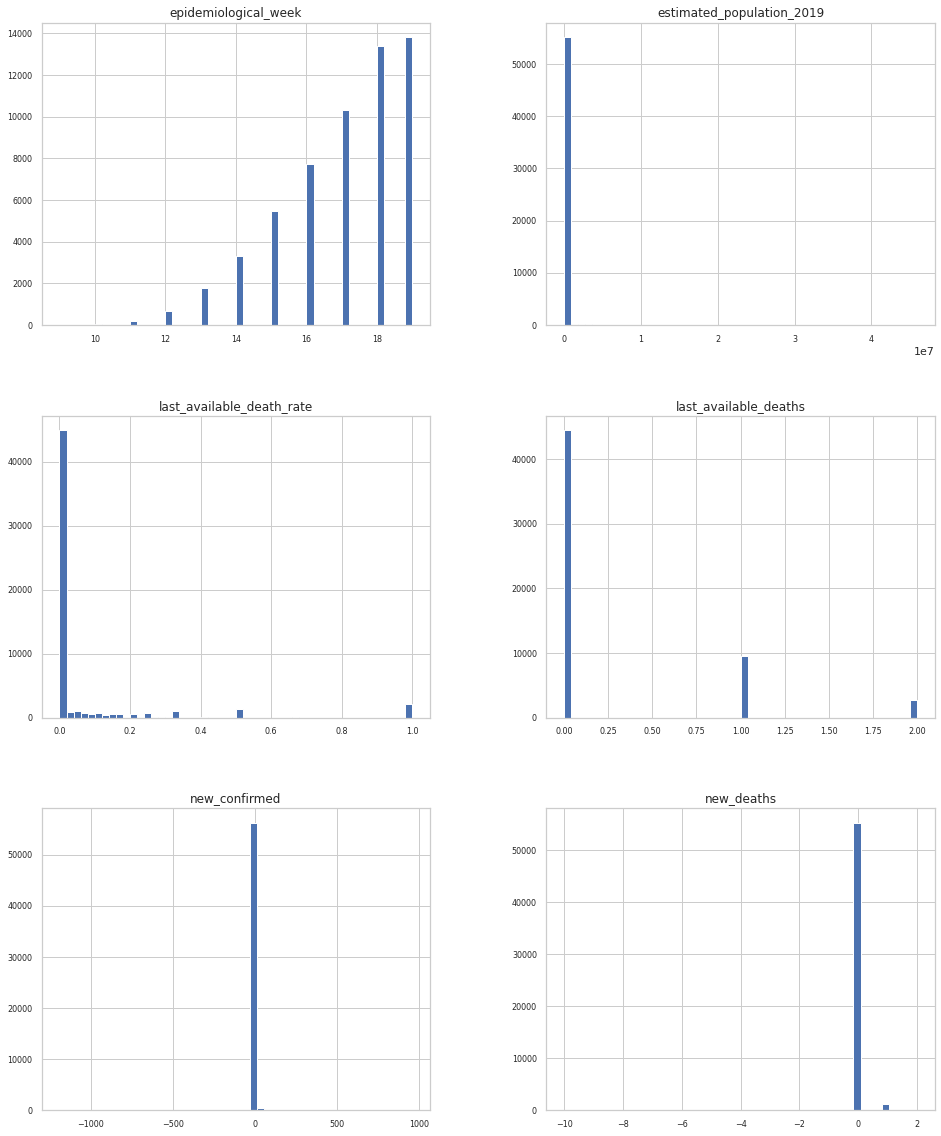

In [71]:
df_num = ds.select_dtypes(include = ['float64', 'int64', 'int8'])

df_num.head()
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [72]:
df_num_corr = df_num.corr()['last_available_deaths'][:-1] 
golden_features_list = df_num_corr[abs(df_num_corr) > 0.1].sort_values(ascending=False)
print("There is {} strongly correlated values with last available deaths:\n{}".format(len(golden_features_list), golden_features_list))

There is 4 strongly correlated values with last available deaths:
last_available_deaths        1.000000
last_available_death_rate    0.558038
new_deaths                   0.282761
epidemiological_week         0.109270
Name: last_available_deaths, dtype: float64


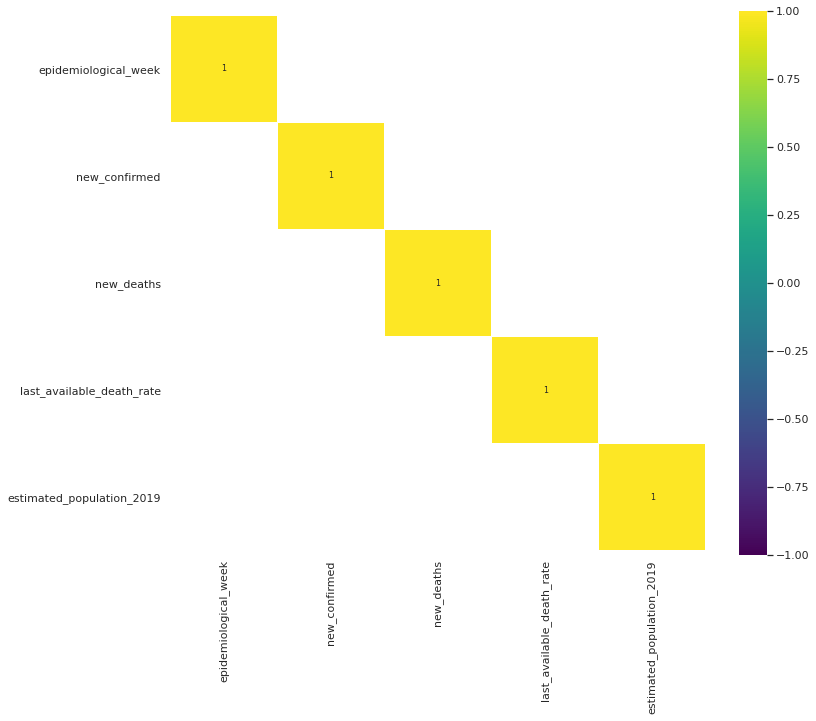

In [73]:
corr = df_num.drop('last_available_deaths', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

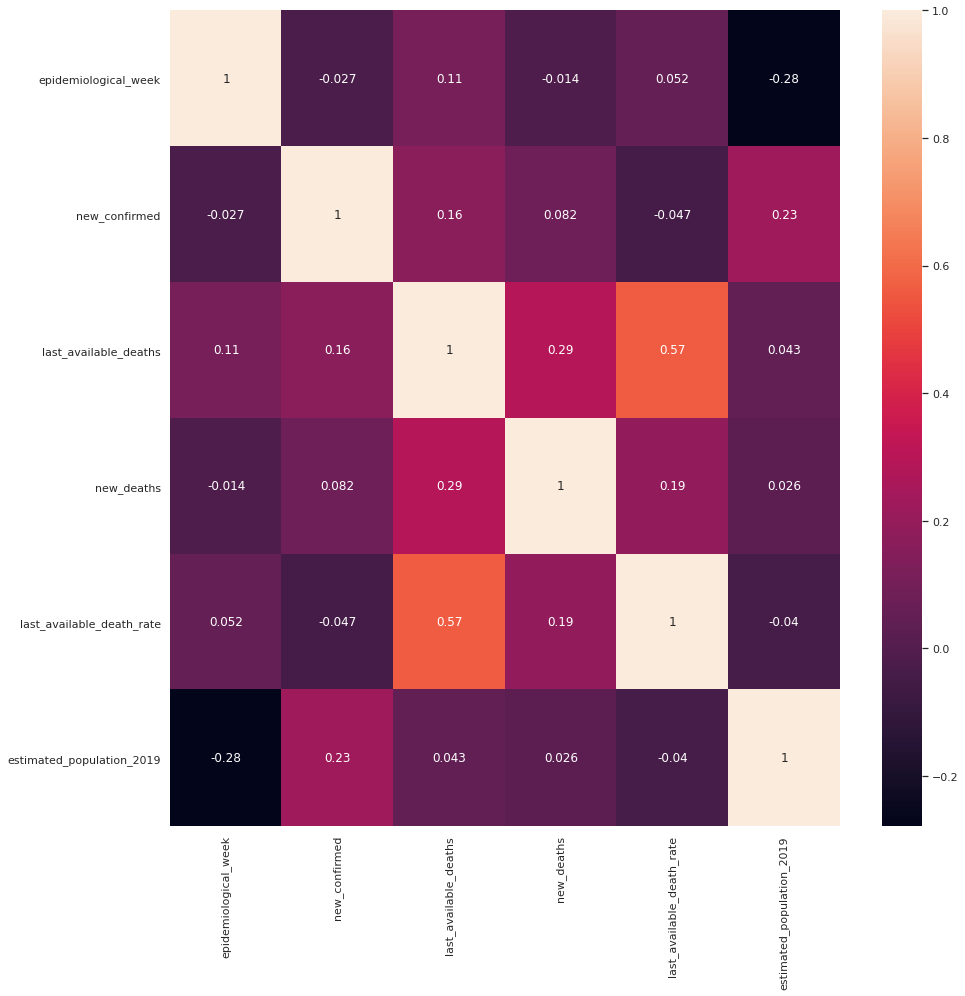

In [98]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(ds.corr(), annot=True)

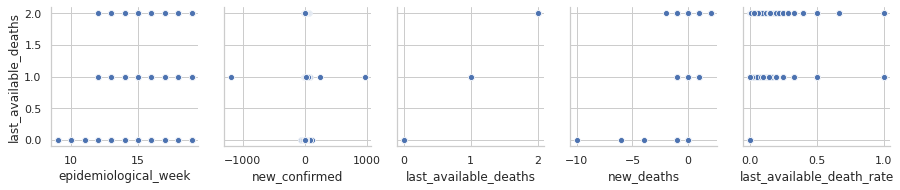

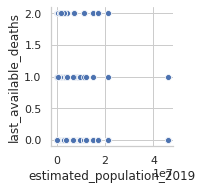

In [75]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['last_available_deaths'])

In [79]:
ds["epidemiological_week"] = pd.to_numeric(ds["epidemiological_week"], errors= "ignore")
ds["new_confirmed"] = pd.to_numeric(ds["new_confirmed"], errors= "ignore")
ds["new_deaths"] = pd.to_numeric(ds["new_deaths"], errors= "ignore")
ds["last_available_death_rate"] = pd.to_numeric(ds["last_available_death_rate"], errors= "ignore")
ds["estimated_population_2019"] = pd.to_numeric(ds["estimated_population_2019"], errors= "ignore")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [0]:
ds = ds.dropna()

In [0]:
x = ds[['epidemiological_week', 'new_confirmed','new_deaths','last_available_death_rate','estimated_population_2019']]
y = ds["last_available_deaths"]

In [81]:
x.isnull().any()
x.shape

(55375, 5)

In [82]:
y.isnull().any()
y.shape

(55375,)

In [83]:
x

,epidemiological_week,new_confirmed,new_deaths,last_available_death_rate,estimated_population_2019
0,19,0,0,0.0667,15256.0
1,19,0,0,0.0000,7417.0
2,19,0,0,0.0000,10266.0
3,19,0,0,0.0000,88376.0
4,19,0,0,0.0000,18411.0
...,...,...,...,...,...
62276,9,0,0,0.0000,12252023.0
62278,9,1,0,0.0000,12252023.0
62280,9,0,0,0.0000,12252023.0
62282,9,0,0,0.0000,12252023.0


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size = 0.30)

In [86]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

rf = linear_model.LinearRegression()
rf.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [87]:
x_test

,epidemiological_week,new_confirmed,new_deaths,last_available_death_rate,estimated_population_2019
19887,18,0,0,0.0,40105.0
28546,18,0,0,0.0,7296.0
60193,13,0,0,0.0,129193.0
39228,17,4,0,0.0,169107.0
9533,19,0,0,0.0,33362.0
...,...,...,...,...,...
29028,18,0,0,0.0,33434.0
54325,15,1,0,0.0,19049.0
32348,17,0,0,0.0,5591.0
11122,19,0,0,0.0,33850.0


In [0]:
pred = rf.predict(x_test)

In [89]:
print("Conjunto de predições:\n {}".format(pred))

Conjunto de predições:
 [0.14647399 0.14389642 0.00703034 ... 0.11447394 0.17527112 0.57493118]


In [90]:
# coeficientes
print('Coeficientes: \n', rf.coef_)
# mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, pred))
# Coeficiente de determinação: 1 é a predição perfeita
print('Coeficiente de determinação: %.2f'
      % r2_score(y_test, pred))

Coeficientes: 
 [2.92885330e-02 3.95918505e-02 5.51476598e-01 1.34712543e+00
 7.85629078e-08]
Mean squared error: 0.17
Coeficiente de determinação: 0.40


In [91]:
pred.shape

(16613,)

In [92]:
x_test.shape

(16613, 5)

In [93]:
y_test.shape

(16613,)

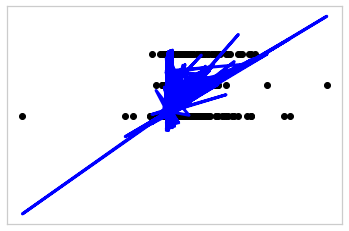

In [95]:
plt.scatter(x_test['new_confirmed'], y_test,  color='black')
plt.plot(x_test['new_confirmed'], pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

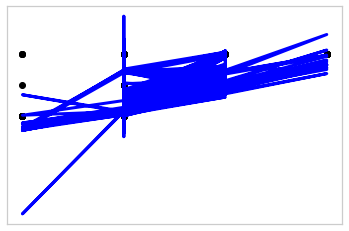

In [96]:
plt.scatter(x_test['new_deaths'], y_test,  color='black')
plt.plot(x_test['new_deaths'], pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [97]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(rf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.3966933159931203


In [0]:
x = x.fillna(method='ffill')
y = y.fillna(method='ffill')

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

In [0]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3)

In [0]:
modelo_regressaoLog = LogisticRegression(C = 0.7, random_state = 42)
modelo_regressaoLog.fit(x_train, y_train.ravel())

regressao_log_predict_test = modelo_regressaoLog.predict(x_test)

In [108]:
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(y_test, regressao_log_predict_test)))
print()
print("Classification Report")
print(metrics.classification_report(y_test, regressao_log_predict_test, labels = [1, 0]))

Exatidão (Accuracy): 0.7820

Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2786
           0       0.78      1.00      0.88     13002

   micro avg       0.78      0.82      0.80     15788
   macro avg       0.39      0.50      0.44     15788
weighted avg       0.64      0.82      0.72     15788

